<h1 style="font-family:verdana;"> <center>Bee VS Wasp Classification using Deep Convolutional Neural Networks and Transfer Learning</center> </h1>

# 🏗️Import Necessary Libraries

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='darkgrid')

2024-12-13 21:03:55.918566: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 21:03:55.962270: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 21:03:55.962498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 21:03:55.967337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 21:03:55.994416: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

2024-12-13 21:03:59.497494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9804 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5


# 🤙Create helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-12-13 21:04:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-13 21:04:02 (40.4 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



# 📥Load and Transform Data

In [4]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [5]:
# Walk through each directory
dataset = "bee_vs_wasp"
walk_through_dir(dataset)

There are 7 directories and 3 images in 'bee_vs_wasp'.
There are 0 directories and 2439 images in 'bee_vs_wasp/other_insect'.
There are 0 directories and 856 images in 'bee_vs_wasp/other_noinsect'.
There are 0 directories and 4943 images in 'bee_vs_wasp/wasp'.
There are 0 directories and 1 images in 'bee_vs_wasp/example_notebook'.
There are 1 directories and 1 images in 'bee_vs_wasp/label_generator'.
There are 0 directories and 1 images in 'bee_vs_wasp/label_generator/.ipynb_checkpoints'.
There are 0 directories and 3184 images in 'bee_vs_wasp/bee'.
There are 0 directories and 2 images in 'bee_vs_wasp/.ipynb_checkpoints'.


# 📅Placing data into a Dataframe
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The first column <b>filepaths</b> contains the file path location of each individual images. The second column <b>labels</b>, on the other hand, contains the class label of the corresponding image from the file path</p>

In [6]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [7]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/kaggle/input/grape-disease-dataset-original").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

/tmp/ipykernel_7343/609307592.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')


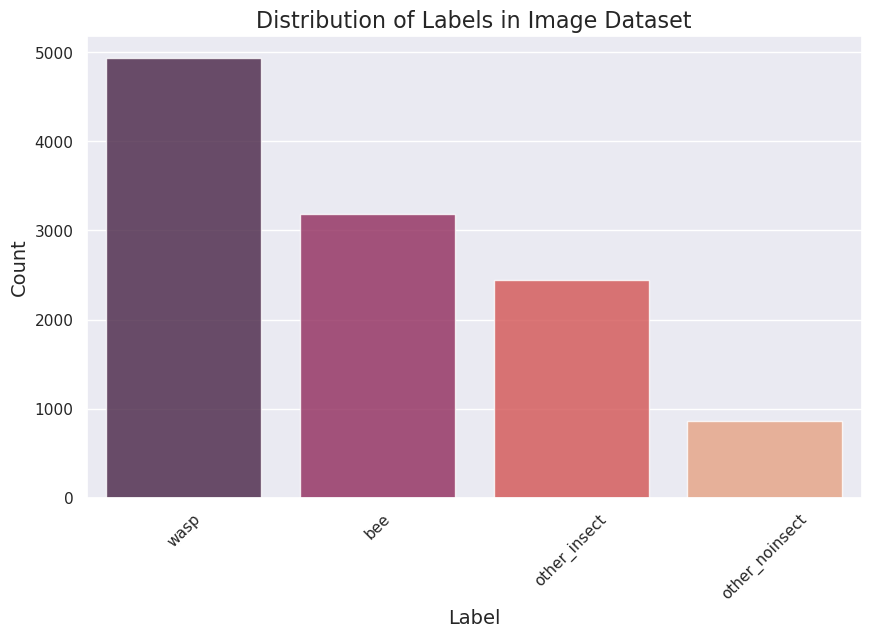

In [8]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.show()


# 🔭Visualizing images from the dataset

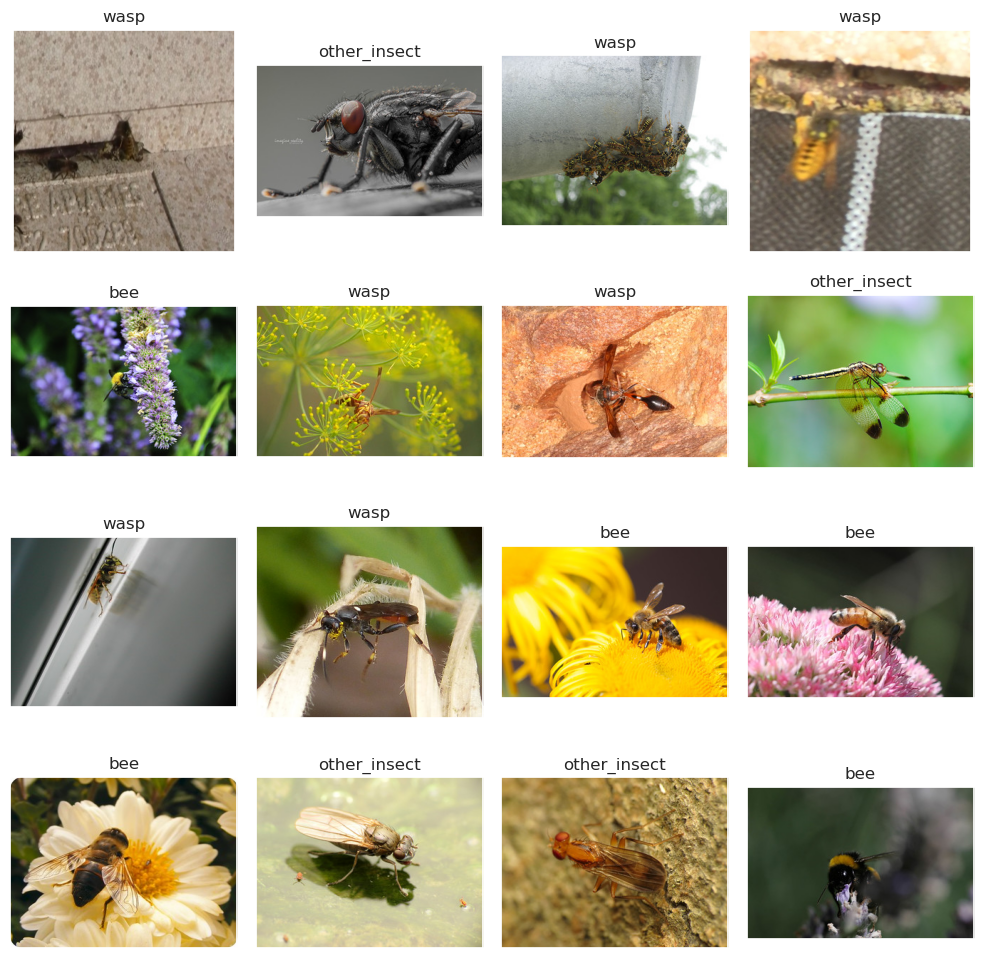

In [9]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 🧮Computing Error Rate Analysis

<p style="font-size:12px; font-family:verdana; line-height: 1.7em">The code below is used for error level analysis (ELA) of images in the context of a pest image classification task.</p>

<p style="font-size:12px; font-family:verdana; line-height: 1.7em">The compute_ela_cv() function takes an image path and a quality parameter, compresses the image using JPEG compression at the given quality, and computes the absolute difference between the compressed and original images. The difference is multiplied by a scale factor and returned as an ELA image.</p>

<p style="font-size:12px; font-family:verdana; line-height: 1.7em">The convert_to_ela_image() function takes an image path and a quality parameter, compresses the image using JPEG compression at the given quality, computes the absolute difference between the compressed and original images, and returns an ELA image. The ELA image is computed using the difference in pixel values between the original and compressed images, and is normalized to enhance the differences.</p>

<p style="font-size:12px; font-family:verdana; line-height: 1.7em">The random_sample() function takes a directory path and an optional file extension, and returns a random file path from that directory with the specified extension (if provided).</p>

<p style="font-size:12px; font-family:verdana; line-height: 1.7em">Finally, the code generates a set of ELA images using the compute_ela_cv() function for a randomly selected image from the test dataset of pest images. The ELA images are generated with decreasing quality levels, resulting in increasing levels of compression and thus increasing levels of error. The resulting images are plotted using matplotlib.</p>

In [10]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

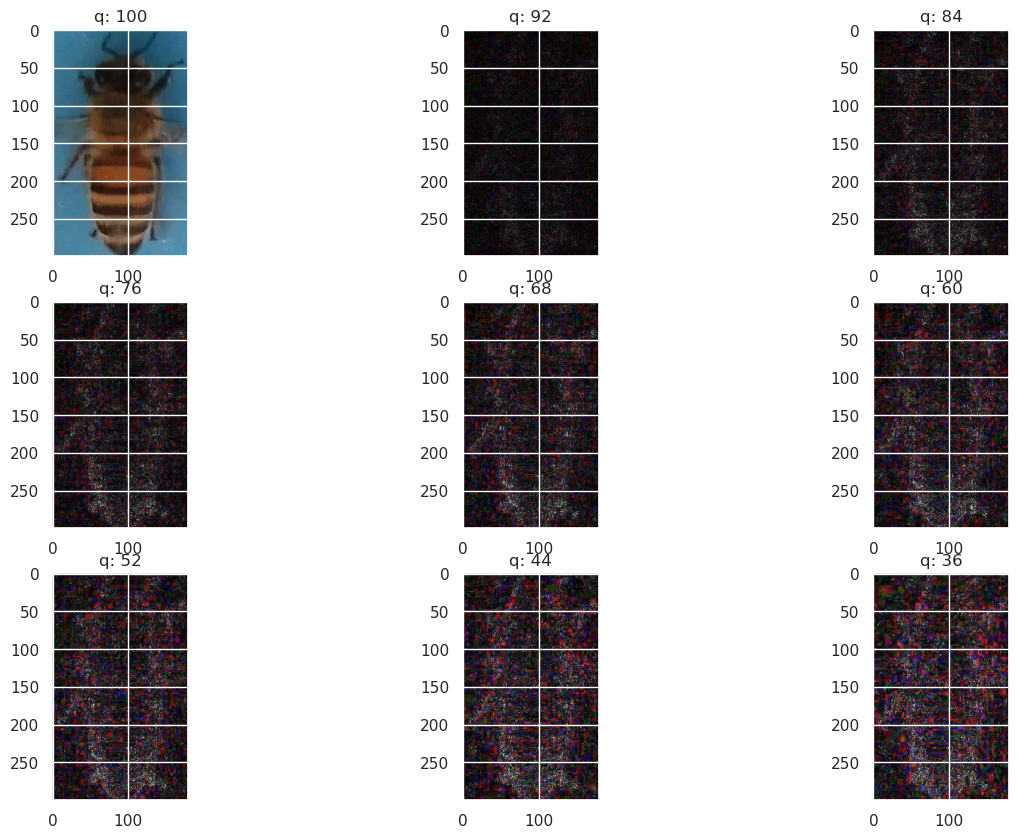

In [11]:
# View random sample from the dataset
p = random_sample('bee_vs_wasp/bee')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# 📝Data Preprocessing
<p style="font-size:12px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>

In [12]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [13]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

In [14]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7309 validated image filenames belonging to 4 classes.
Found 1827 validated image filenames belonging to 4 classes.
Found 2285 validated image filenames belonging to 4 classes.


In [15]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

2024-12-13 21:04:32.641914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9804 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5


# 🤹Training the model
<p style="font-size:12px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

<p style="font-size:12px">
  <strong>Batch size</strong>: 32<br>
  <strong>Epochs</strong>: 100<br>
  <strong>Input Shape</strong>: (224, 224, 3)<br>
  <strong>Output layer</strong>: 12
</p>




In [16]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [17]:
# Create checkpoint callback
checkpoint_path = "pests_cats_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [18]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

# 🚄Training the model

In [19]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Run this only ONCE to train the model then reuse checkpoints saved

In [21]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "pests_cats_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/pests_cats_classification/20241213-085059
Epoch 1/50


2024-12-13 08:51:23.071291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


229/229 [==============================] - 108s 359ms/step - loss: 2.4321 - accuracy: 0.3069 - val_loss: 0.9368 - val_accuracy: 0.6420
Epoch 2/50
229/229 [==============================] - 76s 331ms/step - loss: 1.3950 - accuracy: 0.4499 - val_loss: 0.7976 - val_accuracy: 0.7323
Epoch 3/50
229/229 [==============================] - 76s 332ms/step - loss: 1.1149 - accuracy: 0.5496 - val_loss: 0.7125 - val_accuracy: 0.7553
Epoch 4/50
229/229 [==============================] - 76s 330ms/step - loss: 0.9862 - accuracy: 0.6095 - val_loss: 0.6387 - val_accuracy: 0.7800
Epoch 5/50
229/229 [==============================] - 75s 328ms/step - loss: 0.8938 - accuracy: 0.6523 - val_loss: 0.5863 - val_accuracy: 0.7942
Epoch 6/50
229/229 [==============================] - 76s 329ms/step - loss: 0.8501 - accuracy: 0.6608 - val_loss: 0.5506 - val_accuracy: 0.7947
Epoch 7/50
229/229 [==============================] - 75s 329ms/step - loss: 0.8002 - accuracy: 0.6934 - val_loss: 0.5180 - val_accuracy: 0.

## RUN ME TO GET WEIGHTS WITHOUT TRAINING

In [20]:
model.load_weights(checkpoint_path)

# ✔️Model Evaluation
<p style="font-size:12px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3> 
<p style="font-size:12px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $P = \frac{TP}{TP+FP}$
    </span>
  </center>
</h4>


<h3>Recall(R): </h3> 
<p style="font-size:12px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $R = \frac{TP}{TP+FN}$
    </span>
  </center>
</h4>


<h3>F1 score(F1): </h3>

<p style="font-size:12px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $F1 = 2 \times \frac{TP \times FP}{TP + FP}$
    </span>
  </center>
</h4>





In [21]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

2024-12-13 21:05:33.722996: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


    Test Loss: 0.27476
Test Accuracy: 90.55%


# 📉Visualizing loss curves (ONLY run WHEN run training module)

In [29]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

# 🔮Making predictions on the Test Data

In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

72/72 [==============================] - 17s 158ms/step
The first 5 predictions: ['wasp', 'bee', 'wasp', 'wasp', 'other_noinsect']


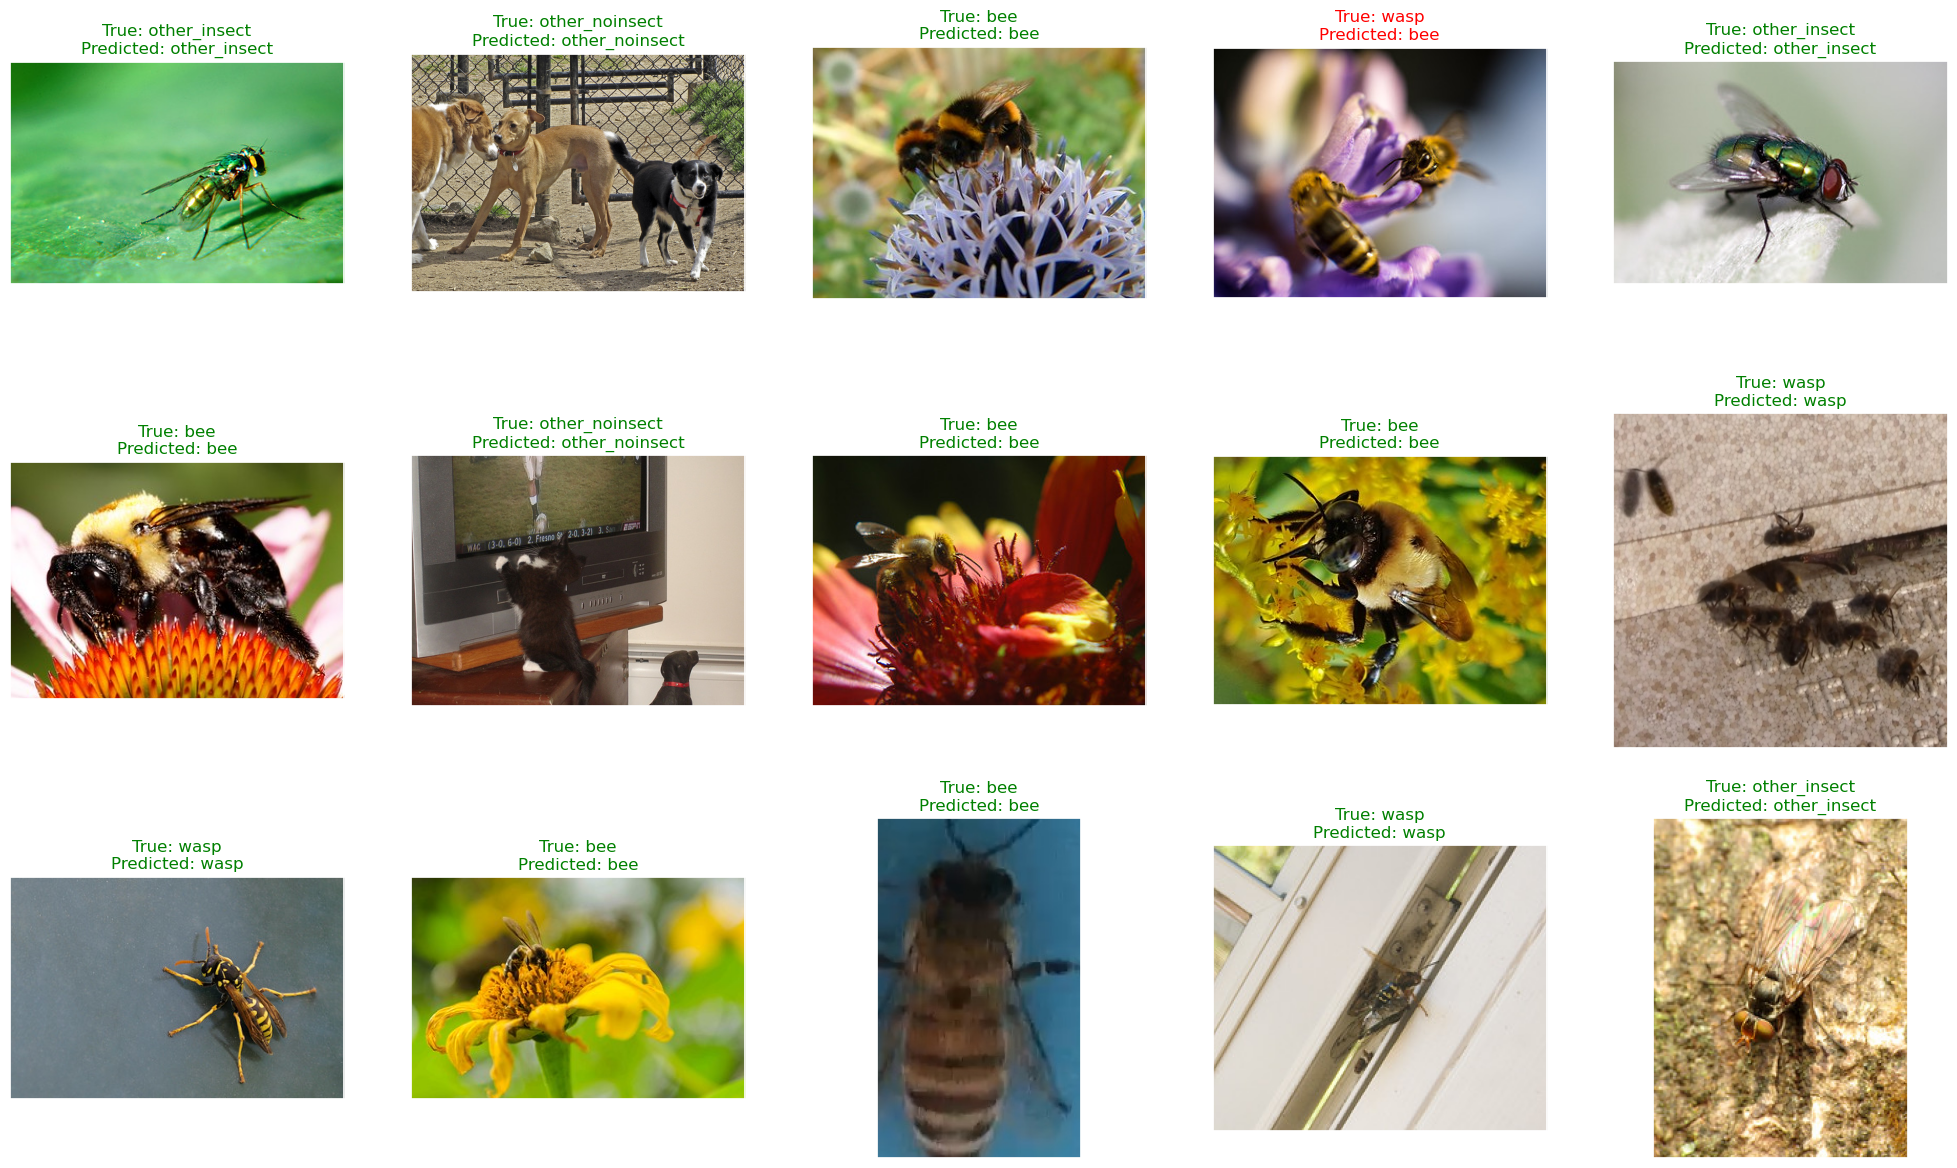

<Figure size 640x480 with 0 Axes>

In [23]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the Classification Reports and Confusion Matrix

<p style="font-size:12px; font-family:verdana; line-height: 1.7em"><b>Confusion matrix</b> and <b>classification report</b> are two important tools used for evaluating the performance of an image classification model.</p>

<p style="font-size:12px; font-family:verdana; line-height: 1.7em">A <b>confusion matrix</b> is a table that summarizes the number of correct and incorrect predictions made by a classification model on a set of test data. It is usually represented as a square matrix with rows and columns representing the predicted and true class labels, respectively. The entries of the matrix indicate the number of test samples that belong to a certain class, and how many of those were classified correctly or incorrectly by the model. A confusion matrix can provide a detailed breakdown of the performance of the model, including measures such as accuracy, precision, recall, and F1-score for each class. It can be used to identify specific areas where the model is making errors, and to diagnose problems with the model's predictions.</p>

<p style="font-size:12px; font-family:verdana; line-height: 1.7em">A <b>classification report</b> is a summary of the key performance metrics for a classification model, including precision, recall, and F1-score, as well as the overall accuracy of the model. It provides a concise overview of the model's performance, typically broken down by class, and can be used to quickly assess the strengths and weaknesses of the model. The report is often presented as a table, with each row representing a class and columns showing various performance metrics. The report may also include other metrics such as support (the number of test samples belonging to a particular class), and the macro- and micro-averages of the performance metrics across all classes.</p>

<p style="font-size:12px; font-family:verdana; line-height: 1.7em">In image classification, both confusion matrix and classification report are important tools for evaluating the performance of the model, identifying areas for improvement, and making decisions about how to adjust the model's architecture or training parameters.</p>

In [24]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

           bee       0.90      0.93      0.92       632
  other_insect       0.94      0.86      0.90       504
other_noinsect       0.88      0.92      0.90       173
          wasp       0.90      0.91      0.90       976

      accuracy                           0.91      2285
     macro avg       0.90      0.91      0.90      2285
  weighted avg       0.91      0.91      0.91      2285



In [25]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
bee              0.904908  0.933544  0.919003   632.00000
other_insect     0.935205  0.859127  0.895553   504.00000
other_noinsect   0.879121  0.924855  0.901408   173.00000
wasp             0.896761  0.907787  0.902240   976.00000
accuracy         0.905470  0.905470  0.905470     0.90547
macro avg        0.903999  0.906328  0.904551  2285.00000
weighted avg     0.906158  0.905470  0.905339  2285.00000

In [26]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


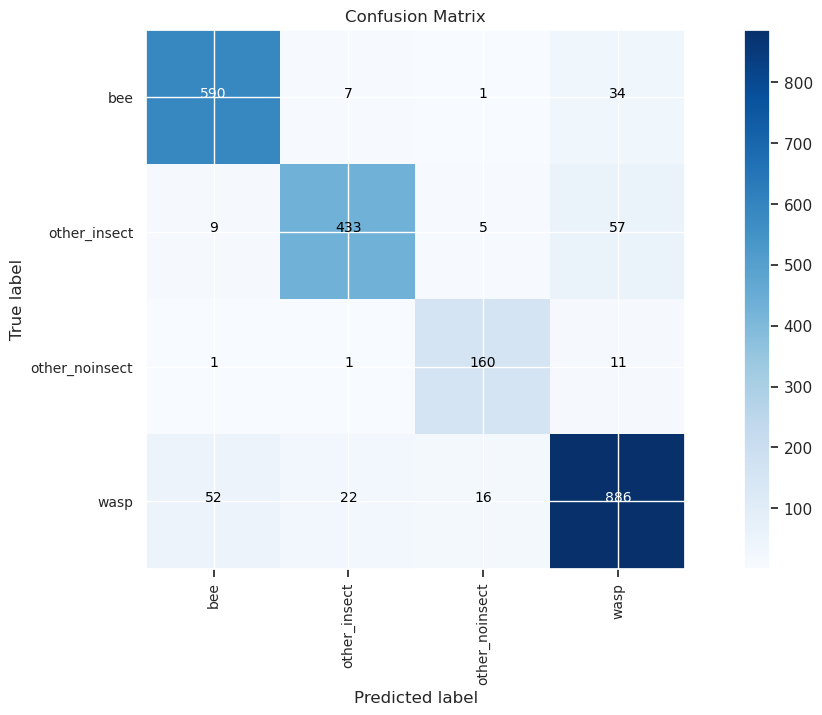

In [27]:
make_confusion_matrix(y_test, pred, list(labels.values()))

# ☀️Grad-Cam Visualization

<p style="font-size:12px; font-family:verdana; line-height: 1.7em"><b>Grad-CAM (Gradient-weighted Class Activation Mapping)</b> is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction. It allows you to see which regions of the image the model focused on while making its prediction. Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.</p>

In [30]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

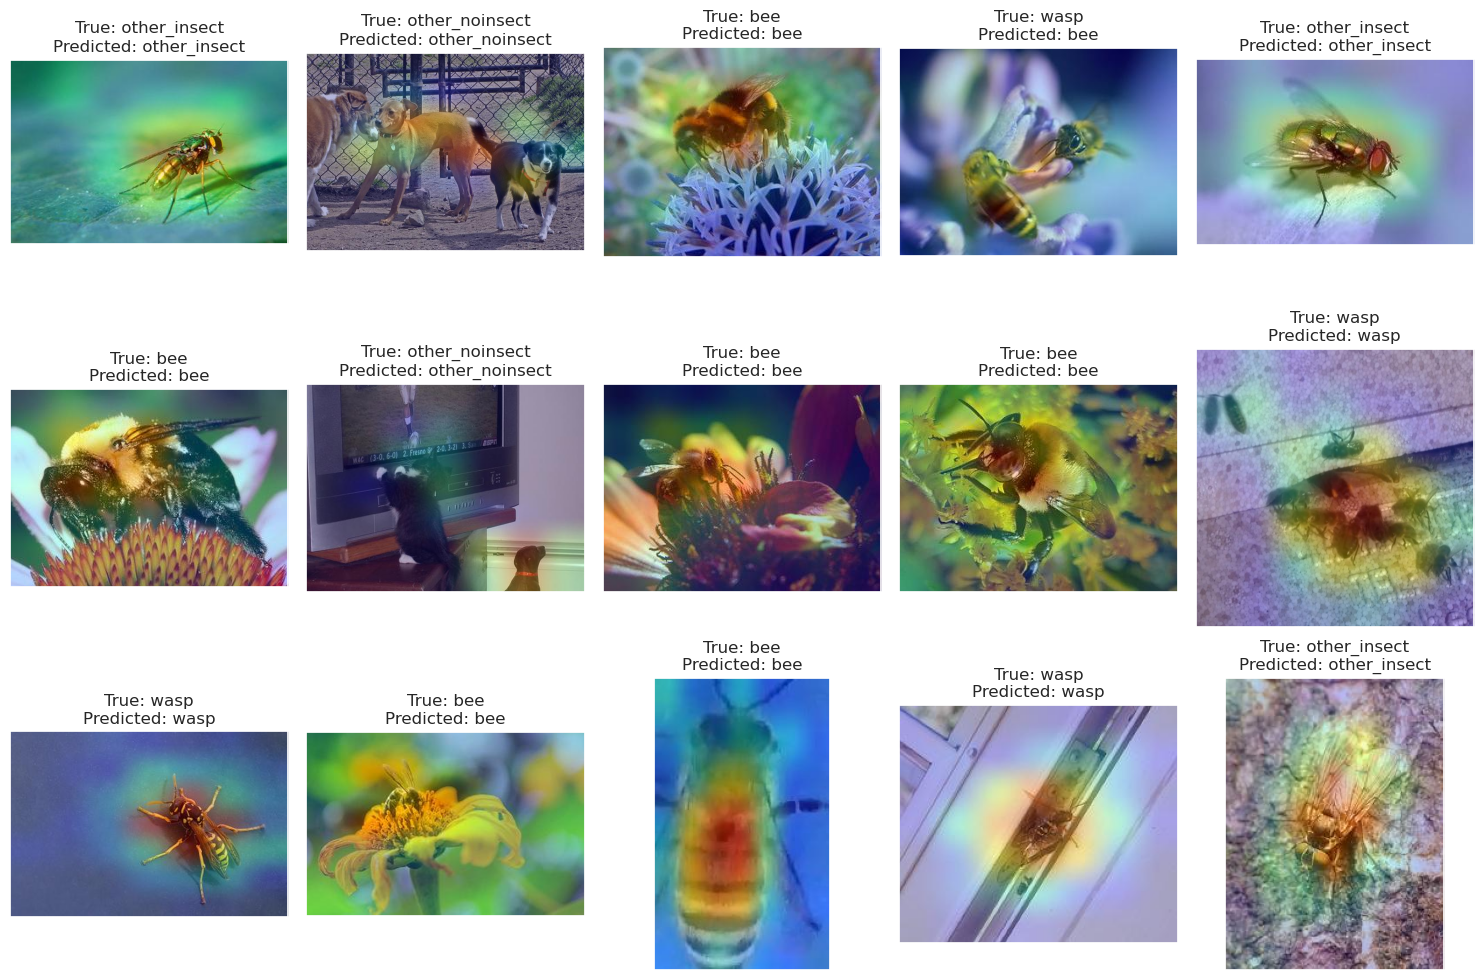

In [31]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

# PCA for features learned


## Picking layer and extracting features

In [32]:
from sklearn.decomposition import PCA

In [37]:
layer1_name = "block1a_project_conv"
layer2_name = "block1a_project_activation"

feature_extractor1 = Model(inputs=model.input, 
                           outputs=model.get_layer(layer1_name).output)
feature_extractor2 = Model(inputs=model.input, 
                           outputs=model.get_layer(layer2_name).output)

In [38]:
images, labels = val_images.next()  # get one batch

features_layer1 = feature_extractor1.predict(images)
features_layer2 = feature_extractor2.predict(images)

print("Layer1 feature shape:", features_layer1.shape)
print("Layer2 feature shape:", features_layer2.shape)

1/1 [==============================] - 0s 91ms/step
Layer1 feature shape: (32, 112, 112, 32)
Layer2 feature shape: (32, 112, 112, 32)


In [39]:
difference = features_layer2 - features_layer1
# 'difference' now contains the element-wise difference of the two feature maps
print("Difference feature shape:", difference.shape)

Difference feature shape: (32, 112, 112, 32)


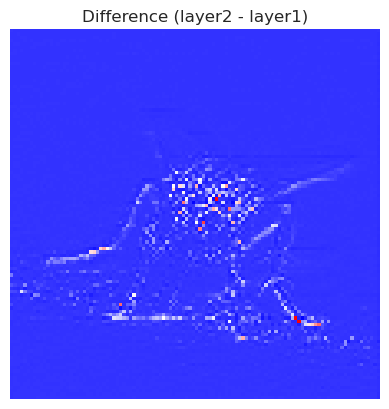

In [40]:
# Assume we are looking at the first image in the batch and first channel
diff_map = difference[0, :, :, 0]

# Normalize for visualization
diff_min, diff_max = diff_map.min(), diff_map.max()
diff_map_norm = (diff_map - diff_min) / (diff_max - diff_min + 1e-5)

plt.imshow(diff_map_norm, cmap='bwr')  # bwr colormap to show positive/negative differences
plt.title("Difference (layer2 - layer1)")
plt.axis('off')
plt.show()

In [41]:
layer_name = "block1a_project_activation"
feature_extractor = Model(inputs=model.input, 
                           outputs=model.get_layer(layer_name).output)

Batch images shape: (32, 224, 224, 3)
1/1 [==============================] - 0s 173ms/step
Feature maps shape: (2, 112, 112, 32)


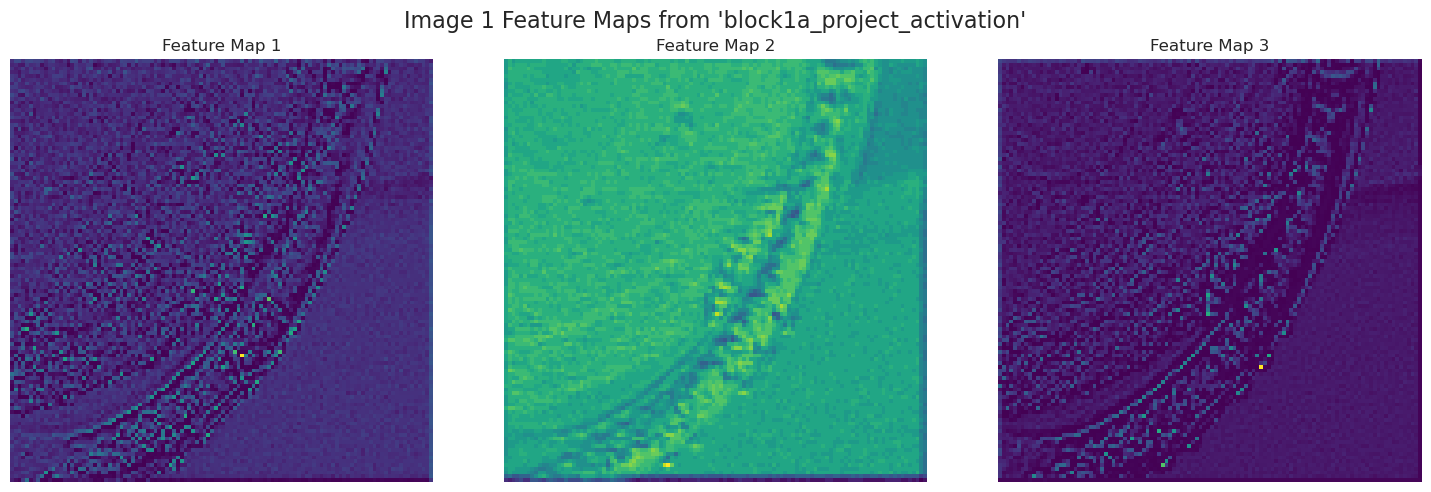

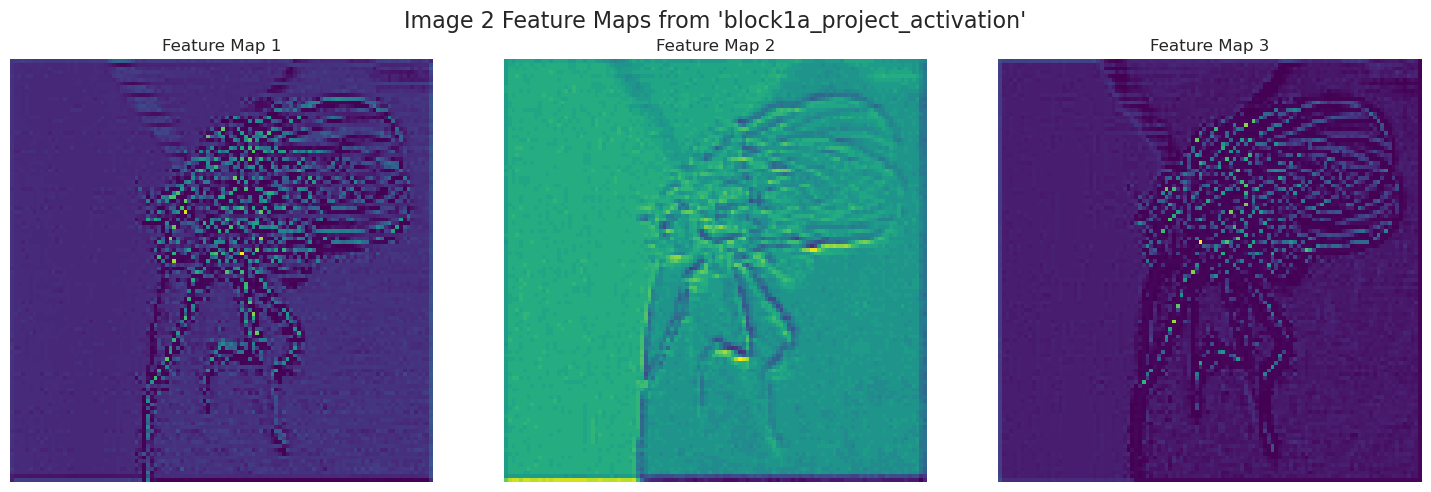

In [42]:
# Get one batch of images (and labels if available) from val_images
images, labels = val_images.next()  # images shape typically: (batch_size, H, W, C)
print("Batch images shape:", images.shape)

# Let's just take a few images from this batch, say the first 2 images
sample_images = images[:2]

# Extract features from the chosen layer
feature_maps = feature_extractor.predict(sample_images)
# feature_maps shape: (2, height, width, channels) depending on the layer output

print("Feature maps shape:", feature_maps.shape)

# Suppose we want to visualize 3 feature maps (channels) for each of the 2 images
num_images = sample_images.shape[0]
num_feature_maps_to_show = 3  # You can increase this if you want more maps

for img_idx in range(num_images):
    # Create a subplot grid for visualization
    fig, axes = plt.subplots(1, num_feature_maps_to_show, figsize=(15, 5))
    fig.suptitle(f"Image {img_idx+1} Feature Maps from '{layer_name}'", fontsize=16)
    
    # For each image, select a few feature maps/channels to display
    for i in range(num_feature_maps_to_show):
        # Extract channel i of the feature map for the image
        fm = feature_maps[img_idx, :, :, i]
        
        # Normalize the feature map for better visualization (optional)
        fm_min, fm_max = fm.min(), fm.max()
        fm = (fm - fm_min) / (fm_max - fm_min + 1e-5)  # Avoid division by zero
        
        axes[i].imshow(fm, cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f"Feature Map {i+1}")
    
    plt.tight_layout()
    plt.show()

## Extract features for PCA

In [43]:
#    Provide a batch of images from your dataset. For PCA, you might want a sample 
#    or the entire validation set. Make sure the dataset is preprocessed as your model expects.

# To get all features from val_images, you might need to iterate over it.

features = []
num_batches = 2
for _ in range(num_batches):
    batch_x, batch_y = val_images.next()  # get next batch from DataFrameIterator
    batch_features = feature_extractor.predict(batch_x)
    features.append(batch_features)

features = np.concatenate(features, axis=0)

print("Extracted features shape:", features.shape)  # (num_samples, feature_dim)

1/1 [==============================] - 0s 62ms/step
Extracted features shape: (64, 112, 112, 32)


## Perform PCA to reduce dimensionality

In [44]:
features = features.reshape(features.shape[0], -1)
pca = PCA()
pca.fit(features)

PCA()

In [45]:
pc1_loadings = pca.components_[0]
important_features_indices = np.argsort(np.abs(pc1_loadings))[::-1]

top_features = features[:, important_features_indices[:100]]
corr_matrix = np.corrcoef(top_features, rowvar=False)

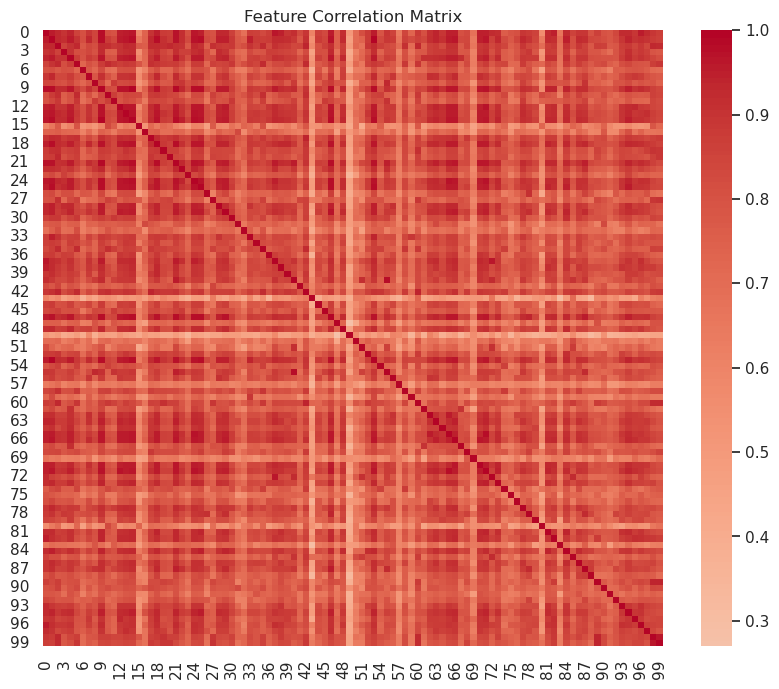

In [46]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

## Earlier layer correlations (WIP)

In [68]:
earlier_layer_name = "top_activation"
earlier_extractor = Model(inputs=model.input,
                          outputs=model.get_layer(earlier_layer_name).output)

images, labels = val_images.next()  # fetch a batch of images
early_features = earlier_extractor.predict(images)

1/1 [==============================] - 5s 5s/step


In [69]:
# Suppose early_features.shape is (batch_size, H, W, channels)
batch_size, H, W, C = early_features.shape
early_features_flat = early_features.reshape(batch_size, -1)  # (batch_size, H*W*C)

In [71]:
pca = PCA(n_components=32)
reduced_early_features = pca.fit_transform(early_features_flat)

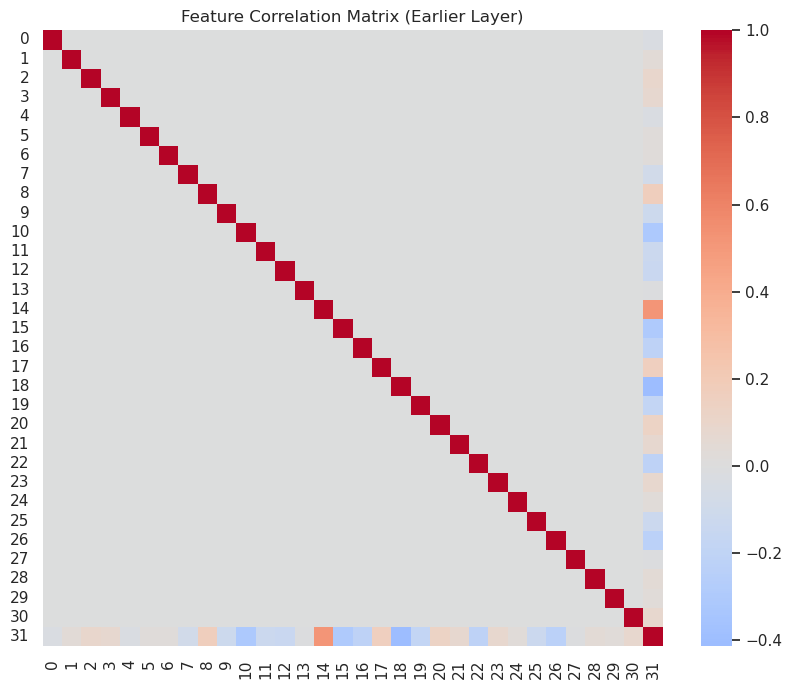

In [72]:
corr_matrix_early = np.corrcoef(reduced_early_features, rowvar=False)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_early, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Earlier Layer)')
plt.show()

## OLD PCA BELOW (possibly discard lol)

Reduced features shape: (64, 2)


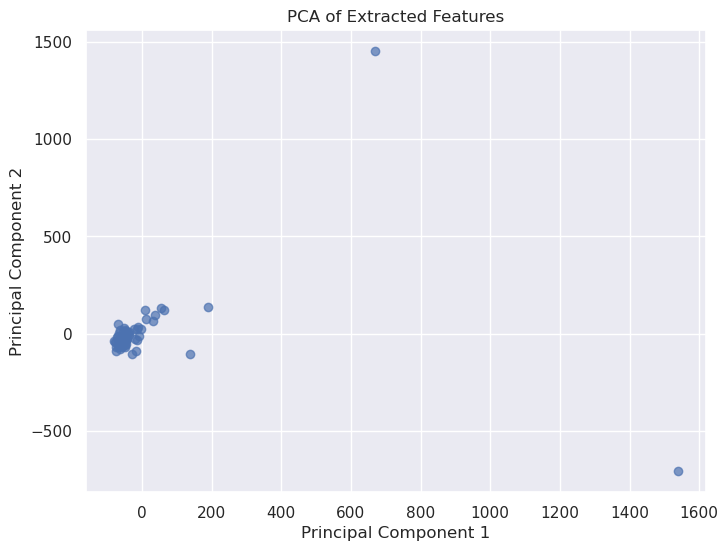

In [50]:
pca = PCA(n_components=2)  # curr just 2 components used for simplicity
reduced_features = pca.fit_transform(features)

print("Reduced features shape:", reduced_features.shape)  # (num_samples, 2)

# 5. Visualize the features
#    If you have labels, you can color-code by class. (optional)
#    Assuming one-hot labels, convert to class indices:
#    class_indices = np.argmax(labels, axis=1)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], 
            reduced_features[:, 1], 
            alpha=0.7)  # Use a fixed alpha for better visualization
plt.title("PCA of Extracted Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()